In [1]:
import numpy as np
# Constants
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2
QUBITS = 4
QC_REPETITIONS = 1
IMAGE_WIDTH = 28
CLASSES = 4
EPOCHS = 10
BATCH_SIZE = 256
PERTURB = True
NOISE_MODE = 's&p' # 'gaussian', 'salt', 'pepper', 's&p'

## Settings
DEBUG = False
FILENAME_PREFIX = "cnn-mnist"
CHOOSE_NEW_TRAINING_DATA = True

TARGETS = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [2]:
# Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random

from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, CrossEntropyLoss, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    BatchNorm2d,
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform


In [3]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = BATCH_SIZE
n_samples = CLASSES * 10000  # We will concentrate on the first 6000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA):
  # Use pre-defined torchvision function to load MNIST train data
  X_train = datasets.MNIST(
      root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
  )

  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(X_train.targets < CLASSES)[0][:n_samples]
  X_train.data = X_train.data[idx]
  X_train.targets = X_train.targets[idx]

  print("X_train.data", X_train.data.shape)
  # Define torch dataloader with filtered data
  train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
  torch.save(train_loader, f'checkpoints/{FILENAME_PREFIX}-training-{CLASSES}.pt')
else:
  train_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-training-{CLASSES}.pt')

X_train.data torch.Size([24754, 28, 28])


images shape torch.Size([256, 1, 28, 28])


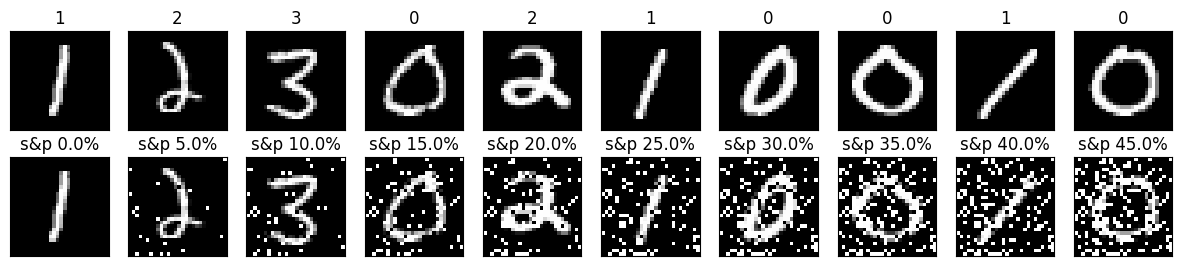

In [4]:
n_samples_show = 9

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show + 1, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show >= 0:
    originalImage = images[n_samples_show,0]
    if(PERTURB and NOISE_MODE == 's&p'):
      perturbedImage = noise(originalImage.numpy(), mode=NOISE_MODE, amount=0.05*n_samples_show)
    elif(PERTURB and NOISE_MODE == 'gaussian'):
      if(n_samples_show == 0):
        perturbedImage = originalImage
      else:
        perturbedImage = noise(originalImage.numpy(), mode=NOISE_MODE)
        for n in range(n_samples_show):
          perturbedImage = noise(perturbedImage, mode=NOISE_MODE)

    perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show].set_xticks([])
    axes[0,n_samples_show].set_yticks([])
    axes[0,n_samples_show].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show].set_xticks([])
      axes[1,n_samples_show].set_yticks([])
      if(NOISE_MODE == 's&p'):
        axes[1,n_samples_show].set_title("{} {}%".format(NOISE_MODE, 0.05*100*n_samples_show))
      else:
        axes[1,n_samples_show].set_title("{} {}".format(NOISE_MODE, n_samples_show))
    else:
      axes[1,n_samples_show].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show].set_xticks([])
      axes[1,n_samples_show].set_yticks([])
      axes[1,n_samples_show].set_title(TARGETS[targets[n_samples_show].item()])
      
    n_samples_show -= 1

In [5]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
manual_seed(5)

n_samples = CLASSES * 1000  # We will concentrate on 1000 * CLASSES samples

if(CHOOSE_NEW_TRAINING_DATA):
  # Use pre-defined torchvision function to load MNIST test data
  X_test = datasets.MNIST(
      root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
  )

  # Filter out labels (originally 0-9), leaving only labels 0 and 1
  idx = np.where(X_test.targets < CLASSES)[0][:n_samples]
  X_test.data = X_test.data[idx]
  X_test.targets = X_test.targets[idx]

  # Define torch dataloader with filtered data
  test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)
  torch.save(test_loader, f'checkpoints/{FILENAME_PREFIX}-testing-{CLASSES}.pt')
else:
  test_loader = torch.load(f'checkpoints/{FILENAME_PREFIX}-testing-{CLASSES}.pt')

In [6]:
# Define torch NN module
OUT_CH = 8

class Net(Module):
    def __init__(self):
      super().__init__()
      self.conv1 = Conv2d(1, OUT_CH, kernel_size=3, stride=4, padding=1)
      self.bn1 = BatchNorm2d(OUT_CH)
      self.relu1 = ReLU()
      self.mp1 = MaxPool2d(kernel_size=3, stride=3) # output: 64 x 16 x 16

      self.conv2 = Conv2d(OUT_CH, 2*OUT_CH, kernel_size=2)
      self.bn2 = BatchNorm2d(2*OUT_CH)
      self.relu2 = ReLU()
      # self.mp2 = MaxPool2d(2, 2) # output: 128 x 8 x 8

      self.fc1 = Linear(2*OUT_CH*6*6, 600)
      self.drop = Dropout2d(0.25)
      self.fc2 = Linear(600, 120)
      self.fc3 = Linear(120, CLASSES)

    def forward(self, x):
      # print("first", x.shape)
      x = self.conv1(x)
      # print("after conv1", x.shape)
      x = self.bn1(x)
      # print("after bn1", x.shape)
      x = self.relu1(x)
      # print("after relu1", x.shape)
      x = self.mp1(x)
      # print("after mp1", x.shape)

      x = self.conv2(x)
      # print("after conv2", x.shape)
      x = self.bn2(x)
      # print("after bn2", x.shape)
      x = self.relu2(x)
      # print("after relu2", x.shape)
      # x = self.mp2(x)
      # print("after mp2", x.shape)
      x = x.view(x.size(0), -1)
      # print("after conv2, bn2, relu2, mp2", x.shape)
      # x = self.fc1(x)
      # x = self.drop(x)
      # x = self.fc2(x)
      # x = self.fc3(x)

      return x


model = Net()

In [7]:
# Define model, optimizer, and loss function
start_time = datetime.now()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
epochs = EPOCHS  # Set number of epochs
loss_list = []  # Store loss history
model.train()  # Set model to training mode
# m = Softmax(dim=3)

print("Training Set size:", len(train_loader.dataset), "Epochs", EPOCHS, "Batch Size:", BATCH_SIZE, "Number of batches:", (len(train_loader.dataset)//BATCH_SIZE)+1)
total_loss = []
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        if(DEBUG):
          print("epoch", epoch, "batch", batch_idx)
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        print(epoch, batch_idx, "Loss", loss.item())
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
    torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-q{QUBITS}-r{QC_REPETITIONS}-c{CLASSES}-{epoch}.pt')
end_time = datetime.now()
elapsed = end_time - start_time
print("Training Time: {:.0f} seconds]".format(elapsed.total_seconds()))

Training Set size: 24754 Epochs 10 Batch Size: 256 Number of batches: 97
0 0 Loss 3.038172960281372
0 1 Loss 3.0495333671569824
0 2 Loss 2.959388017654419
0 3 Loss 2.9547367095947266
0 4 Loss 2.9294774532318115
0 5 Loss 2.90278697013855
0 6 Loss 2.978055953979492
0 7 Loss 2.933072328567505
0 8 Loss 2.9616501331329346
0 9 Loss 2.828860282897949
0 10 Loss 2.854302167892456
0 11 Loss 2.814833641052246
0 12 Loss 2.820483684539795
0 13 Loss 2.8503708839416504
0 14 Loss 2.8066511154174805
0 15 Loss 2.7964580059051514
0 16 Loss 2.8159210681915283
0 17 Loss 2.725759506225586
0 18 Loss 2.6765081882476807
0 19 Loss 2.777012586593628
0 20 Loss 2.673421621322632
0 21 Loss 2.6874256134033203
0 22 Loss 2.653064727783203
0 23 Loss 2.7061455249786377
0 24 Loss 2.7195305824279785
0 25 Loss 2.652003049850464
0 26 Loss 2.6835806369781494
0 27 Loss 2.624040126800537
0 28 Loss 2.634648561477661
0 29 Loss 2.6586971282958984
0 30 Loss 2.5917341709136963
0 31 Loss 2.61079478263855
0 32 Loss 2.5401723384857178

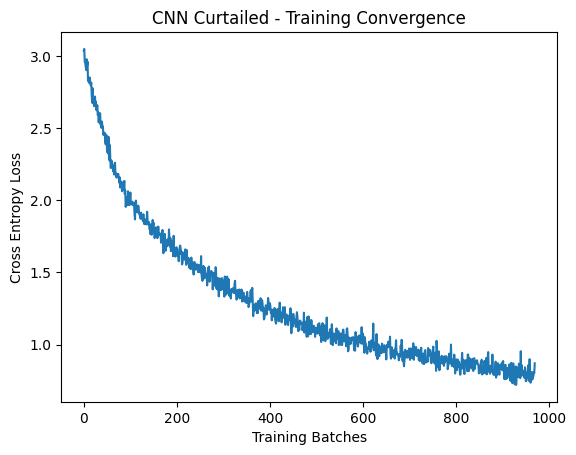

In [8]:
# Plot loss convergence
plt.plot(total_loss)
plt.title("CNN Curtailed - Training Convergence")
plt.xlabel("Training Batches")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [9]:
torch.save(model.state_dict(), f'checkpoints/{FILENAME_PREFIX}-q{QUBITS}-r{QC_REPETITIONS}-c{CLASSES}.pt')

In [10]:
def plotKernel(ax, locations, kernels, tunings, title):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
  ax.plot([0, 0],[IMAGE_WIDTH, IMAGE_WIDTH])
  cycol = cycle('bgrcmk')
  Y = []
  X = []
  C=[]
  S=[]
  kernelSize=[]
  tuningX=[]
  tuningY=[]
  tuningValue=[]
  for iy, ix in np.ndindex(locations.shape):
    y = locations[iy, ix] // imgWidth
    x = locations[iy, ix] % imgWidth
    Y.append(y)
    X.append(x)
    ks = kernels[iy, ix].item()
    kernelSize.append(ks * ks * 2000/(IMAGE_WIDTH*IMAGE_WIDTH))
    tuningX.append(x + ks/2)
    tuningY.append(y + ks/2)
    size = kernels[iy, ix].item()
    S.append(size)
    tuningValue.append(tunings[iy, ix].item())
    ax.add_patch(Rectangle((x.item(), y.item()), size, size, facecolor= 'none', edgecolor=next(cycol), alpha=0.75))
  ax.scatter(tuningX, tuningY,c=tuningValue, s=kernelSize, cmap='Greys', alpha=0.75)
    # print(x.item(), y.item(), kernels[iy, ix].item())



In [13]:
n_samples_show = 6
count = 0

with no_grad():
  imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1

  print("Testing Set size:", len(test_loader.dataset), "Batch Size:", BATCH_SIZE, "Number of batches:", (len(test_loader.dataset)//BATCH_SIZE)+1)
  epoch = 9

  for noise_amount in range(10):
    total_loss = []
    correct = 0
    model = Net()
    model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-q{QUBITS}-r{QC_REPETITIONS}-c{CLASSES}-{epoch}.pt'))
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
      perturbations = []
      perturbedData = data

      if(PERTURB and NOISE_MODE == 's&p'):
        dataWithNoise = noise(data.numpy(), mode=NOISE_MODE, amount=0.05*noise_amount)
      elif(PERTURB and NOISE_MODE == 'gaussian'):
        if(noise_amount == 0):
          dataWithNoise = data
        else:
          dataWithNoise = noise(data.numpy(), mode=NOISE_MODE)
          for n in range(noise_amount):
            dataWithNoise = noise(dataWithNoise, mode=NOISE_MODE)
      perturbedData = torch.tensor(dataWithNoise).type(torch.FloatTensor)

      output = model(perturbedData)
      # print("prediction output", output)
      print(batch_idx+1, end=" ")
      if len(output.shape) == 1:
          output = output.reshape(1, *output.shape)

      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

      loss = loss_func(output, target)
      total_loss.append(loss.item())
      count += 1

    print(
        "Performance on test data:\n\tNoise: {}%, Loss: {:.4f}\n\tClasses: {}, \n\tAccuracy: {:.1f}%".format(
            0.05*100*noise_amount, 
            sum(total_loss) / len(total_loss), 
            CLASSES, correct / len(test_loader) / batch_size * 100
        )
    )


Testing Set size: 4000 Batch Size: 256 Number of batches: 16
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 0.0%, Loss: 0.7890
	Classes: 4, 
	Accuracy: 81.8%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 5.0%, Loss: 1.1642
	Classes: 4, 
	Accuracy: 67.8%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 10.0%, Loss: 1.4940
	Classes: 4, 
	Accuracy: 54.2%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 15.0%, Loss: 1.8066
	Classes: 4, 
	Accuracy: 44.3%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 20.0%, Loss: 2.0486
	Classes: 4, 
	Accuracy: 39.3%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 25.0%, Loss: 2.1591
	Classes: 4, 
	Accuracy: 37.2%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 30.0%, Loss: 2.2593
	Classes: 4, 
	Accuracy: 35.1%
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 Performance on test data:
	Noise: 

In [12]:
import qiskit.tools.jupyter

%qiskit_version_table